# BK2 physics: Simulation of a mass on a spring

## Theory

Consider a bead of mass $m$ on a spring with spring constant $k$. 

We can embed figures: 
<img src="force-in-springs.jpg" alt="Drawing" style="width: 300px;"/>

We can embed images directly from the net (if you are sure it will stay there): 
<img src="
https://upload.wikimedia.org/wikipedia/commons/f/f0/HookeFlea01.jpg
" alt="Drawing" style="width: 300px;" title="Drawing of a flea, Robert Hooke, 1665"/>

Hooke's law: 
$
  F = -kx
$

Newton's second law:
$$
F = ma = m \frac{d^2 x}{dt^2}
$$

## Simulation

We will setup a numerical simulation using the Python programming language. 
First we do some technical preparations:

In [1]:
### TECHNICAL STUFF START ####
import numpy as np
import matplotlib.pyplot as plt
import numba
%matplotlib notebook
### TECHNICAL STUFF END ###


Now we are ready to define our Python function which will simulate a mass attached a to spring, using the LeapFrog method. 

** NOTE: you have to change the line a = ... **

In [2]:
@numba.njit
def run(m, k, dt, t_end, v0, x0):
    """ Run a numerical simulation of a mass and a spring using the Leap-Frog method """
    
    n_steps = int(t_end/dt)  # Number of steps
    
    ttable = np.zeros(n_steps)
    xtable = np.zeros(n_steps)
    vtable = np.zeros(n_steps)
    
    t = 0.0
    x = x0
    v = v0
    
    for i in range(n_steps):
        t = t + dt
        #a = ...
        a = -k*x/m    # Newton II and Hooke combined
        v = v + a*dt  # a = dv/dt
        x = x + v*dt  # v = dx/dt
        
        ttable[i] = t
        xtable[i] = x
        vtable[i] = v
    
    return ttable,xtable,vtable

Now we are ready to run the simulation:

** NOTE: you have to insert the numbers describing the simulation you want **

In [3]:
#ttable,xtable,vtable = run(m=, k=, dt=, t_end=, v0=, x0=)   
ttable, xtable, vtable  = run(m=2.0, k=1.0, dt=0.00001, t_end=10.0, v0=0.0, x0=0.1) 
ttable2,xtable2,vtable2 = run(m=2.0, k=1.0, dt=0.1,     t_end=10.0, v0=0.0, x0=0.1) 

Let's plot x as a function of t, using the data stored in the tables:

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(ttable,xtable,'-', label='dt=0.00001')
plt.plot(ttable2,xtable2,'.--', label='dt=0.1')
plt.title("Simulation of a bead on a spring")
plt.xlabel("time, t [s]")
plt.ylabel("position, x [m]")
plt.legend(loc='lower right')
plt.show()
plt.savefig('spring.pdf')

<IPython.core.display.Javascript object>

### Timing function without Numba

In [5]:
time_nonumba = %timeit -o ttable,xtable,vtable = run.py_func(m=2.0, k=1.0, dt=0.00001, t_end=10.0, v0=0.0, x0=0.1) 

407 ms ± 8.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Timing function with Numba

In [6]:
time_numba = %timeit -o ttable,xtable,vtable = run(m=2.0, k=1.0, dt=0.00001, t_end=10.0, v0=0.0, x0=0.1) 

11.4 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
SpeedUp = time_nonumba.average/time_numba.average
print('Speed-up by using numba:', SpeedUp)

Speed-up by using numba: 35.730577437821694


### Utilizing a GPU 

In [27]:
from numba import cuda
import math
cuda.api.detect()

Found 1 CUDA devices
id 0      b'GeForce GTX 650'                              [SUPPORTED]
                      compute capability: 3.0
                           pci device id: 0
                              pci bus id: 1
Summary:
	1/1 devices are supported


True

In [9]:
@cuda.jit
def spring_gpu(m, k, dt, t_end, Te, max_x):
    """ Run a numerical simulation of a mass and a spring """
    
    global_id = cuda.grid(1)
    my_Te = Te[global_id]

    m = numba.float32(m)
    k = numba.float32(k)
    t = numba.float32(0.0)
    x = numba.float32(0.0)
    v = numba.float32(0.0)
    F0 = numba.float32(0.1)
    omega = numba.float32(2.0*np.pi/my_Te)
    my_max_x = numba.float32(0.0)
    
    for i in range(int(t_end/dt)):
        t = t + dt
        Fe = F0*math.cos(omega*t)
        a = (-k*x + Fe)/m    
        v = v + a*dt  # a = dv/dt
        x = x + v*dt  # v = dx/dt
        
        if x>my_max_x:
            my_max_x = x

    max_x[global_id] = my_max_x
      

In [10]:
m = 1
k = 1
dt = 0.001
t_end = 1000
num_Te = 512

Te = np.linspace(1,10,num_Te).astype(np.float32)
max_x = np.zeros(num_Te).astype(np.float32)

spring_gpu[num_Te//32,32](m, k, dt, t_end, Te, max_x)

<IPython.core.display.Javascript object>


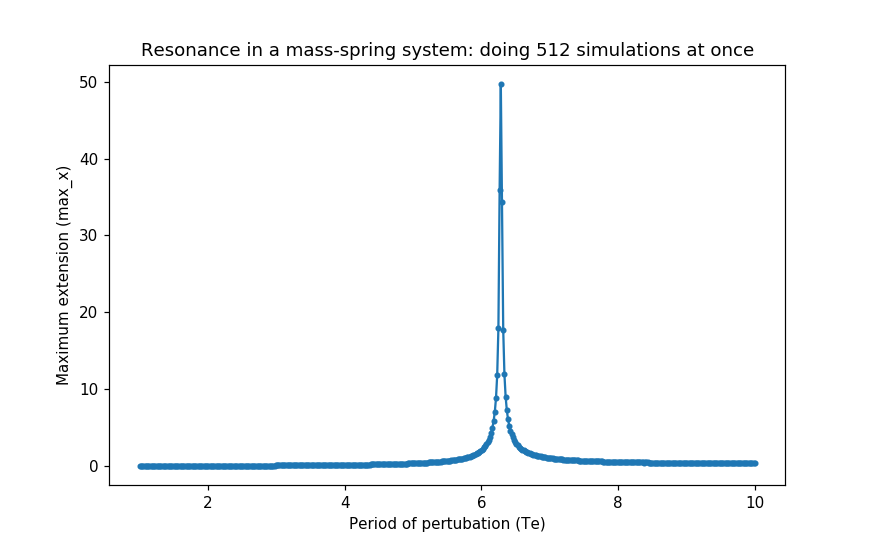

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(Te, max_x, '.-')
plt.title(f"Resonance in a mass-spring system: doing {num_Te} simulations at once")
plt.xlabel("Period of pertubation (Te)")
plt.ylabel("Maximum extension (max_x)")
plt.show()
plt.savefig('resonance.pdf')

In [12]:
time_gpu = %timeit -o  spring_gpu[num_Te//32,32](m, k, dt, t_end, Te, max_x)

1.28 s ± 408 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
SpeedUp = num_Te*time_numba.average/time_gpu.average
print('Speed-up by using GPU (compared to CPU-numba):', SpeedUp)

Speed-up by using GPU (compared to CPU-numba): 4.566523042585314
